In [27]:
from sklearn import svm
import pickle as pkl
import numpy as np
import random
import keras
import glob
import pickle
import sklearn
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier


In [28]:
# Load file
def load_file(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# Load features of the pictures
def load_features(filename):
    all_features = pkl.load(open(filename, 'rb'))

    return all_features

def train_svm(feature_vector,labels):
    #model = svm.SVC(C=10, kernel='sigmoid', verbose=True)
    #model = RandomForestClassifier(criterion="entropy", random_state=0)
    model = BaggingClassifier(base_estimator=RandomForestClassifier(criterion="entropy",n_estimators=5,random_state=0), n_estimators=5, random_state=0, verbose=1, n_jobs=-1)
    model.fit(feature_vector,labels)
    return model

def predict_image(svm_model,path,target_size=224):
    model = VGG16()
    # Modify model to remove the last layer
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

    image = load_img(path, target_size=(target_size, target_size))
    image = img_to_array(image)

    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    img_feature = model.predict(image, verbose=0)
    return svm_model.predict(list(img_feature))

In [31]:
positive_features = load_features('REAL_TRAIN.pkl')
negative_features = load_features('SPOOF_TRAIN.pkl')[:len(positive_features)]

print("training non-spoofed images:", len(positive_features))
print("training spoofed_images:", len(negative_features))

positive_labels = list(np.zeros((len(positive_features)),int))
negative_labels = list(np.ones((len(negative_features)),int))

combined = list(zip(positive_features, positive_labels))
random.shuffle(combined)
positive_features[:], positive_labels[:] = zip(*combined)
positive_features = [fes.reshape(-1) for fes in positive_features]

combined2 = list(zip(negative_features, negative_labels))
random.shuffle(combined2)
negative_features[:], negative_labels[:] = zip(*combined2)
negative_features = [fes.reshape(-1) for fes in negative_features]

both_features = np.concatenate((positive_features, negative_features))
both_labels = np.concatenate((positive_labels, negative_labels))

print(len(both_features))


training non-spoofed images: 2081
training spoofed_images: 2081
4162


In [32]:
model = train_svm(both_features,both_labels)
print(model)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s


BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
  

[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s finished


In [33]:
filename = "model.pkl"
pickle.dump(model, open(filename, 'wb'))

# some time later...

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [34]:
from sklearn.metrics import accuracy_score

In [35]:
positive_features_test = load_features('REAL_TEST.pkl')
positive_features_test = [fes.reshape(-1) for fes in positive_features_test]

negative_features_test = load_features('SPOOF_TEST.pkl')[:len(positive_features_test)]
negative_features_test = [fes.reshape(-1) for fes in negative_features_test]

positive_labels_test = list(np.zeros((len(positive_features_test)),int))
negative_labels_test = list(np.ones((len(negative_features_test)),int))

print("Test images not spoofed:",len(positive_features_test))
print("Test images spoofed:",len(negative_features_test))

both_features_test = np.concatenate((positive_features_test, negative_features_test))
both_labels_test   = np.concatenate((positive_labels_test, negative_labels_test))

Test images not spoofed: 493
Test images spoofed: 493


In [36]:
predicted = model.predict(both_features_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


In [37]:
# get the accuracy
accuracy_score(both_labels_test, predicted)*100

91.78498985801217

In [41]:
filename = "best_model.pkl"
loaded_model = pickle.load(open(filename, 'rb'))

In [42]:
predicted = loaded_model.predict(both_features_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


In [43]:
accuracy_score(both_labels_test, predicted)*100

91.78498985801217

Automatically created module for IPython interactive environment
[[488   5]
 [ 76 417]]


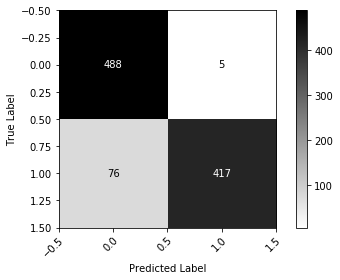

In [45]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(both_labels_test, predicted,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.binary):
 

    # Compute confusion matrix
    cm = confusion_matrix(both_labels_test, predicted)
    # Only use the labels that appear in the dat
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
           # ... and label them with the respective list entries
           ylabel='True Label',
           xlabel='Predicted Label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(both_labels_test, predicted)


plt.show()

In [46]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(both_labels_test, predicted)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


Average precision-recall score: 0.91


In [47]:
from sklearn.metrics import classification_report
print(classification_report(both_labels_test, predicted))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92       493
           1       0.99      0.85      0.91       493

    accuracy                           0.92       986
   macro avg       0.93      0.92      0.92       986
weighted avg       0.93      0.92      0.92       986

